In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
from bayesian_hyperparameter_optimisation_3 import BayesianOptimisation


def generate_noisy_data_from_bivariate_gaussian(z):
    
    "Define a simple 2-D gaussian to generate noisy data"
    
    x = z[:,0].reshape(-1,1)
    y = z[:,1].reshape(-1,1)
    return 1-np.exp(-((x-5)/10)**2)*np.exp(-((y-10)/10)**2)+0.1*np.random.uniform(size=(100,1))#,loc=0,scale=1)


# --- Generate our training data

# Generate random x data from 0 to 15
X_train = 15*np.random.uniform(size=(100,2))
# Generate noisy data from a 2D gaussian defined above
y_train = generate_noisy_data_from_bivariate_gaussian(X_train)
y_train = y_train.ravel()


# --- Define our hyper parameter space as a dictionary. 

# Use the names of the hyper parameters as the keys
# Values should be a list for discrete values and [lower_bound,upper_bound] for continuous
hps = {
    'n_estimators':range(1,10),
    'max_depth':range(1,10)
}

# --- Run the Bayesian Optimisation Code

BOout = BayesianOptimisation(
    hps=hps,
    MLmodel = RandomForestRegressor(random_state=42),
    optim_rout = 'MCMC-discrete',
    NpI = 2,
    Niter = 5,
    y_train = y_train,
    X_train = X_train
).optimise()

INFO:root:Will perform 5 iterations
INFO:root:Iteration 0
INFO:root:Iteration 1
INFO:root:Iteration 2


('current accuracy:', 0.7703572529591407)
('best accuracy:', 0.9140368247138129)
('current accuracy:', 0.8833396367502306)
('best accuracy:', 0.9140368247138129)


INFO:root:Iteration 3


('current accuracy:', 0.8774177900861069)
('best accuracy:', 0.9140368247138129)


INFO:root:Iteration 4


('current accuracy:', 0.859860423119495)
('best accuracy:', 0.9140368247138129)


INFO:root:Best result 0.914036824714: Params: [7. 7.]
INFO:root:Best result 0.914036824714: Params: {'warm_start': 7.0, 'oob_score': 7.0}


('current accuracy:', 0.8704097512107701)
('best accuracy:', 0.9140368247138129)


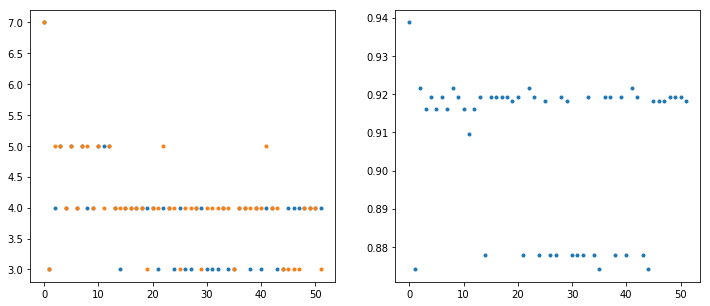

In [39]:
# --- Track the results with each iteration

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(BOout.Xt,'.')
plt.subplot(122)
plt.plot(BOout.Yt,'.')

plt.show()

In [40]:
best_params = BOout.Xt[np.argmax(BOout.Yt)]
RFr = RandomForestRegressor(
    n_estimators=int(best_params[0]),
    max_depth=int(best_params[1]),
    random_state=42
).fit(X_train,y_train)
np.mean(cross_val_score(RFr, X_train,y_train, cv=5))

0.9387873440061991

In [44]:
import os
print os.getcwd()

/Users/crookm12/Documents/GitHub/BayesianOptimisation
